In [12]:
from scipy.stats import bernoulli
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Use seed for reproducibility
seed = 20160  # seed random number generators for reproducibility

In [13]:
from mlforecast.utils import generate_daily_series

series = generate_daily_series(
    n_series=20,
    max_length=100,
    n_static_features=1,
    static_as_categorical=False,
    with_trend=True
)
series.head()

,ds,y,static_0
unique_id,,,
id_00,2000-01-01,1.751917,72
id_00,2000-01-02,9.196715,72
id_00,2000-01-03,18.577788,72
id_00,2000-01-04,24.520646,72
id_00,2000-01-05,33.418028,72


In [19]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import warnings 

models = [
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]

warnings.filterwarnings("ignore")

In [21]:
from mlforecast import Forecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

In [22]:
@njit
def rolling_mean_28(x):
    return rolling_mean(x, window_size=28)

fcst = Forecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_28]
    },
    date_features=['dayofweek'],
    differences=[1],
)

In [24]:
fcst.fit(series, id_col='index', time_col='ds', target_col='y', static_features=['static_0'])

Forecast(models=[XGBRegressor, RandomForestRegressor], freq=<Day>, lag_features=['lag-7', 'lag-14', 'expanding_mean_lag-1', 'rolling_mean_28_lag-7'], date_features=['dayofweek'], num_threads=1)

In [25]:
predictions = fcst.predict(14)
predictions

,ds,XGBRegressor,RandomForestRegressor
unique_id,,,
id_00,2000-04-04,67.761337,68.184016
id_00,2000-04-05,74.588699,75.470680
id_00,2000-04-06,81.058289,82.846249
id_00,2000-04-07,88.735947,90.201271
id_00,2000-04-08,44.981384,46.096322
...,...,...,...
id_19,2000-03-23,31.949095,32.656369
id_19,2000-03-24,32.765919,33.624488
id_19,2000-03-25,33.628864,34.581486


FileNotFoundError: [Errno 2] No such file or directory: 'figs/index.png'

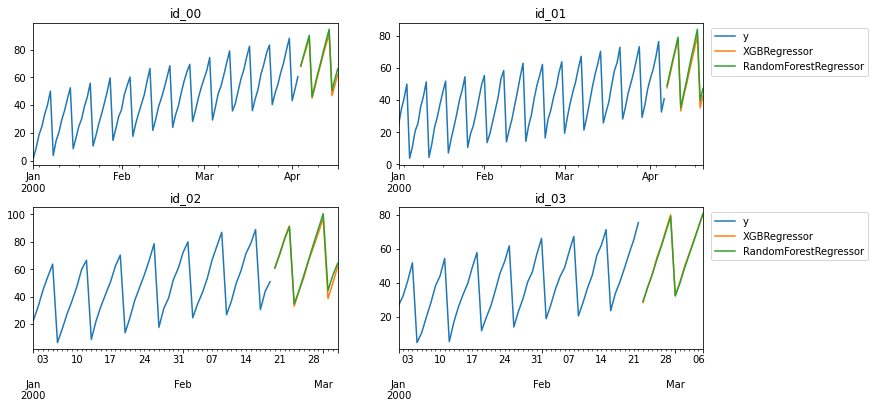

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), gridspec_kw=dict(hspace=0.3))
for i, (cat, axi) in enumerate(zip(series.index.categories, ax.flat)):
    pd.concat([series.loc[cat, ['ds', 'y']], predictions.loc[cat]]).set_index('ds').plot(ax=axi)
    axi.set(title=cat, xlabel=None)
    if i % 2 == 0:
        axi.legend().remove()
    else:
        axi.legend(bbox_to_anchor=(1.01, 1.0))
fig.savefig('figs/index.png', bbox_inches='tight')
plt.close()

In [27]:
df = pd.read_csv('processed/rwa_sum_features.csv')
df['identifier'] = df['product_id'].astype(str) + '-' + df['name']

df1 = df[['identifier', 'imports']]
df.head()

# chunks = list()
# chunk_size = 
# num_chunks = len(df) // chunk_size + 1

# for i in range(num_chunks):
#     chunks.append(df[i * chunk_size : (i + 1) * chunk_size])

,name,year,location_id,partner_id,product_id,imports,exports,len_name,rank,identifier
0,special transactions,1999,187,116,866,26714940,0,20,1,866-special transactions
1,telecom,1999,187,231,1287,10609571,0,7,2,1287-telecom
2,books & paper,1999,187,231,1403,7716548,0,13,3,1403-books & paper
3,food products,1999,187,231,699,4474472,0,13,4,699-food products
4,healthcare goods,1999,187,231,699,4474472,0,16,5,699-healthcare goods


In [28]:
len(df)

31258

In [30]:
G = nx.Graph()

G = nx.from_pandas_edgelist(df1, 'identifier', 'imports')

#some properties
print("node degree clustering")
for v in nx.nodes(G):
    print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

# print()
print("the adjacency list")
for line in nx.generate_adjlist(G):
    print(line)
pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

node degree clustering
866-special transactions 503 0
26714940 1 0
1287-telecom 270 0
10609571 1 0
1403-books & paper 505 0
7716548 1 0
699-food products 153 0
4474472 2 0
699-healthcare goods 153 0
1288-telecom 586 0
4232632 1 0
1286-telecom 541 0
2675487 1 0
882-food products 65 0
2118276 1 0
685-food products 224 0
1583072 1 0
720-leather 230 0
1571218 2 0
720-food products 230 0
1315-vehicles & parts 518 0
1532758 1 0
1525726 2 0
1364138 1 0
1347272 1 0
669-food products 282 0
1334670 1 0
1097788 1 0
1042887 1 0
1284-telecom 581 0
964866 1 0
960299 1 0
948929 1 0
947981 1 0
890388 2 0
795806 1 0
815-clothing 677 0
783854 1 0
1316-vehicles & parts 224 0
772735 1 0
1317-vehicles & parts 235 0
765921 1 0
746994 1 0
829-food products 176 0
711987 1 0
1378-special transactions 433 0
704279 1 0
658076 1 0
637256 1 0
617860 1 0
684-food products 59 0
578726 1 0
674-food products 87 0
570544 1 0
560876 1 0
1400-books & paper 572 0
557430 1 0
1404-plastic 485 0
518747 1 0
512355 1 0
1126-me

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'